In [1]:
import keras
import numpy as np
import pretty_midi
import librosa
import glob
import os
import matplotlib.pyplot as plt
import librosa.display
import IPython.display as ipd
from train_util import NoteIsoSequence
from train_util import get_autoencoder, get_vae, get_gan
from train_util import program_map, one_hot_map
from keras import backend as K
import time
import sklearn

# synthesize without label and then add back for train?
# loud not at the end to force normalization?

Using TensorFlow backend.


In [2]:
midi_root_dir = "/home/faraaz/workspace/music-transcription/data/clean_midi/"
wav_files = glob.iglob(os.path.join(midi_root_dir, '**', '*.wav'))
wav_files = [wav_file for wav_file in wav_files]
num_wav_files = len(wav_files)
print(num_wav_files)
train_wav_files = wav_files[:num_wav_files//4]
test_wav_files = wav_files[:1]
wav_file = wav_files[0]
print(wav_file)

500
/home/faraaz/workspace/music-transcription/data/clean_midi/Redbone/Come and Get Your Love.wav


In [3]:
sf2_path="/usr/share/sounds/sf2/FluidR3_GM.sf2"
sample_rate = 32000
sample_duration = 2 * sample_rate
n_fft = 2048
epsilon = 0.00001
batch_size = 4
midi_file = wav_file[:-4] + ".mid"
pm = pretty_midi.PrettyMIDI(midi_file)
pm_samples = pm.fluidsynth(fs=sample_rate, sf2_path=sf2_path)

In [4]:
instr_id = 0
note_id = 0
instrument = pm.instruments[instr_id]
print(instrument.notes[note_id])
note = instrument.notes[note_id]
sample_start = int(note.start * sample_rate)

Note(start=51.199068, end=51.318113, pitch=81, velocity=105)


In [5]:
padded_samples = pm_samples[:]
if len(padded_samples > sample_start+sample_duration):
    print("hi")
    print(pm_samples.shape)
    padded_samples = padded_samples[sample_start:sample_start+sample_duration]
if len(padded_samples) < sample_duration:
    padded_samples = np.pad(padded_samples, (0, sample_duration-len(padded_samples)), 
                                'constant', constant_values=(0,0))

hi
(10043769,)


In [6]:
print(padded_samples.shape)
print(padded_samples[-1])
ipd.Audio(padded_samples, rate=sample_rate)

(64000,)
-0.05516061084781464


(1025, 126)
(0.01231394+0j)


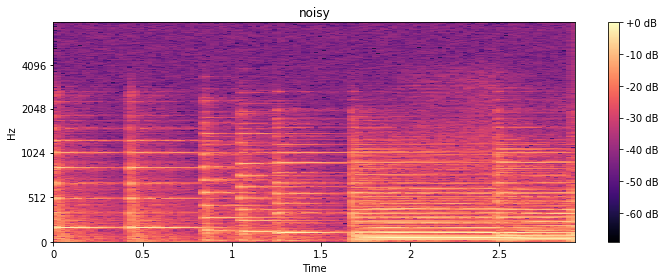

In [7]:
noisy_stft = librosa.core.stft(y=padded_samples, n_fft=n_fft)
print(noisy_stft.shape)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(np.abs(noisy_stft), ref=np.max), 
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('noisy')
plt.tight_layout()
print(noisy_stft[-1][-1])

In [8]:
final_noisy = np.stack((noisy_stft.real, noisy_stft.imag), axis=2)
print(final_noisy.shape)

(1025, 126, 2)


In [9]:
annotation = np.zeros((1, final_noisy.shape[1], final_noisy.shape[2]))
print(annotation.shape)
annotation[0,0,0] = note.pitch
annotation[0,0,1] = note.end - note.start
final_input = np.append(final_noisy, annotation, axis=0)
print(final_input.shape)

(1, 126, 2)
(1026, 126, 2)


In [10]:
velocity = 96
pitch = 60
duration = 1
pm_iso = pretty_midi.PrettyMIDI()
iso_instrument = pretty_midi.Instrument(instrument.program, is_drum=False)
iso_note = pretty_midi.Note(velocity, pitch, 0, duration)
iso_instrument.notes = [iso_note]
pm_iso.instruments = [iso_instrument]

pm_iso_samples = pm_iso.fluidsynth(fs=sample_rate, sf2_path=sf2_path)
if len(pm_iso_samples) > sample_duration:
    pm_iso_samples = pm_iso_samples[:sample_duration]
if len(pm_iso_samples) < sample_duration:
    pm_iso_samples = np.pad(pm_iso_samples, (0, sample_duration-len(pm_iso_samples)), 
                            'constant', constant_values=(0,0))

ipd.Audio(pm_iso_samples, rate=sample_rate)

(1025, 126)


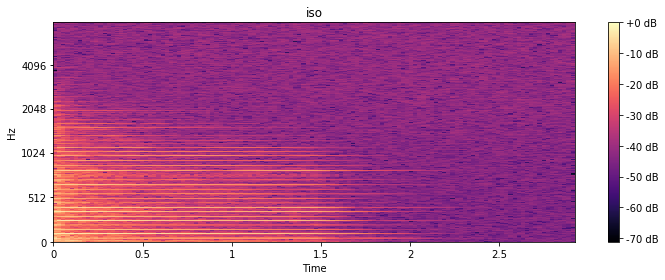

In [11]:
iso_stft = librosa.core.stft(y=pm_iso_samples, n_fft=n_fft)
print(iso_stft.shape)
plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(np.abs(iso_stft), ref=np.max), 
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('iso')
plt.tight_layout()

In [12]:
# convert complex numbers to magnitude and phase
magnitude = np.abs(iso_stft)
phase = np.angle(iso_stft)
log_magnitude = np.log(magnitude)
largest_magnitude = max(np.abs(np.amin(log_magnitude)), np.amax(log_magnitude))
magnitude_scale_factor = largest_magnitude * 1.25  # will scale range to [-0.8, 0.8]
scaled_magnitude = log_magnitude / magnitude_scale_factor
print("mag scale factor {}".format(magnitude_scale_factor))
scaled_phase = phase / (np.pi * 1.25)

print("mag unscaled [{}, {}]".format(np.amin(magnitude), np.amax(magnitude)))
print("mag scaled [{}, {}]".format(np.amin(scaled_magnitude), np.amax(scaled_magnitude)))
print("phase unscaled [{}, {}]".format(np.amin(phase), np.amax(phase)))
print("phase scaled [{}, {}]".format(np.amin(scaled_phase), np.amax(scaled_phase)))

final_iso = np.stack((magnitude, phase), axis=2)
print(final_iso.shape)

rev_magnitude = np.exp(scaled_magnitude * magnitude_scale_factor)
assert np.allclose(magnitude, rev_magnitude)
rev_phase = scaled_phase * (np.pi * 1.25)
assert np.allclose(phase, rev_phase)

rev_iso = magnitude * np.exp(1j*phase)
assert iso_stft.shape == rev_iso.shape
assert np.allclose(iso_stft, rev_iso)

final_iso = final_iso[:-1, :, :]  # shape (1024, 126, 2)
print(final_iso.shape)
final_iso_pad = np.zeros((1024, 2, 2))
final_iso = np.concatenate((final_iso, final_iso_pad), axis=1)  # shape (1024, 128, 2)
print(final_iso.shape)

mag scale factor 14.262492656707764
mag unscaled [1.1084148354711942e-05, 143.81735229492188]
mag scaled [-0.7999999523162842, 0.34836435317993164]
phase unscaled [-3.1415927410125732, 3.1415927410125732]
phase scaled [-0.800000011920929, 0.800000011920929]
(1025, 126, 2)
(1024, 126, 2)
(1024, 128, 2)


In [13]:
print("loading model")
model_type = 'ae'

if model_type == 'ae':
    encoder = keras.models.load_model("ae/encoder-1.h")
    decoder = keras.models.load_model("ae/decoder-1.h")
    _, _, autoencoder = get_autoencoder(encoder, decoder)
    
elif model_type == 'vae':
    _, _, _, my_vae_loss = get_vae()
    autoencoder = keras.models.load_model('vae/vae-0.h', custom_objects={'my_vae_loss': my_vae_loss})
elif model_type == 'gan':
    autoencoder = keras.models.load_model('gan/ae-0.h')
else:
    assert False

loading model


/home/faraaz/anaconda3/envs/urop/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [14]:
instr_indices = [0, 1, 2]
note_indices = [0, 50, 100]
song_indices = [0, 0, 0]
test_generator = NoteIsoSequence([wav_file], sample_duration=sample_duration, 
                                 fs=sample_rate, n_fft=n_fft, instr_indices=instr_indices,
                                 note_indices=note_indices, song_indices=song_indices, batch_size=1)

In [15]:
predicted_encode = encoder.predict_generator(test_generator)
print(len(predicted_encode))
print(predicted_encode.shape)
predicted_decode = decoder.predict(predicted_encode)
print(predicted_decode.shape)
predicted_ae = autoencoder.predict_generator(test_generator)
print(predicted_ae.shape)
print(np.all(predicted_decode == predicted_ae))

3
(3, 256)
(3, 1024, 128, 2)
(3, 1024, 128, 2)
True


-0.825191
0.8303895
0
0
Instrument(program=33, is_drum=False, name="")


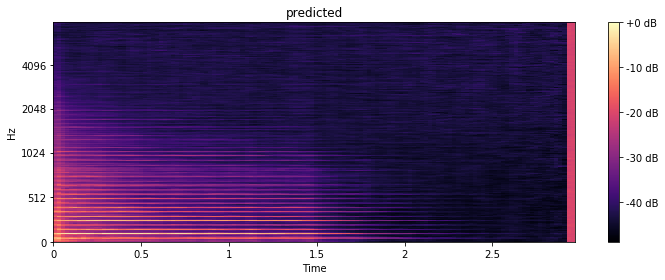

In [26]:
instr_id = 1
predicted_iso = predicted_ae[instr_id]

print(np.amin(predicted_iso))
print(np.amax(predicted_iso))
print(np.count_nonzero(np.isnan(predicted_iso)))
print(np.count_nonzero(np.abs(predicted_iso[:,:,1]) == 1))
predicted_magnitude = np.exp(predicted_iso[:,:,0] * magnitude_scale_factor)
predicted_phase = predicted_iso[:,:,1] * (np.pi * 1.25)
predicted_stft = predicted_magnitude * np.exp(1j*predicted_phase)
print(pm.instruments[instr_id])

plt.figure(figsize=(10, 4))
librosa.display.specshow(librosa.power_to_db(predicted_magnitude, ref=np.max), 
                         y_axis='mel', fmax=8000, x_axis='time')
plt.colorbar(format='%+2.0f dB')
plt.title('predicted')
plt.tight_layout()

In [27]:
predicted_audio = librosa.core.istft(predicted_stft)
ipd.Audio(predicted_audio, rate=sample_rate)

In [18]:
print(np.amin(predicted_magnitude))
print(np.amax(predicted_magnitude))
print(np.amin(predicted_phase))
print(np.amax(predicted_phase))
print(predicted_iso[-1,-1,:])

0.0016379013
123.02634
-3.2405176
3.260932
[-0.03427602 -0.03742763]


In [19]:
# instr_indices = list(range(3))*50 #[]
# note_indices = list(range(50))*3 #[]
# song_indices = [0]*150 #[]
instr_indices = [] #[0, 1, 2] * 10
note_indices = [] #list(range(3)) * 10#[0, 50, 100]
song_indices = [] #[0, 0, 0] * 10
test_generator = NoteIsoSequence(test_wav_files, sample_duration=sample_duration, 
                                 fs=sample_rate, n_fft=n_fft, instr_indices=instr_indices,
                                 note_indices=note_indices, song_indices=song_indices, batch_size=1)

mid_file = test_wav_files[0][:-4] + ".mid"
pm = pretty_midi.PrettyMIDI(mid_file)
num_instruments = len(pm.instruments)
print(num_instruments)
kmeans = sklearn.cluster.KMeans(n_clusters=num_instruments)
embeddings = encoder.predict_generator(test_generator)
print(embeddings.shape)

num_instr 3
instrument Instrument(program=1, is_drum=False, name="Piano1")
num_notes 497
np.amax(n_indices) 496
len 497
instrument Instrument(program=33, is_drum=False, name="")
num_notes 450
np.amax(n_indices) 449
len 947
instrument Instrument(program=28, is_drum=False, name="")
num_notes 1264
np.amax(n_indices) 1263
len 2211
self.song_indices [0, 0, 0, 0, 0, 0, 0, 0]
self.instr_indices [2, 2, 2, 2, 2, 2, 2, 2]
self.note_indices [1256, 1257, 1258, 1259, 1260, 1261, 1262, 1263]
data_size 2211
rounded_size 2211
3
(2211, 256)


In [20]:
embed_clusters = kmeans.fit_predict(embeddings)
cluster_dict = {}
for i in range(len(instr_indices)):
    instr_id = instr_indices[i]
    cluster_id = embed_clusters[i]
    if cluster_id not in cluster_dict:
        cluster_dict[cluster_id] = [0]*num_instruments
    cluster_dict[cluster_id][instr_id] += 1

for cluster_id in range(num_instruments):
    print("{}. {}".format(cluster_id, cluster_dict[cluster_id]))
    

0. [139, 100, 298]
1. [137, 144, 411]
2. [221, 206, 555]


In [21]:
print(embeddings[0])
print(embeddings[1])

[-2.64672940e+07 -1.56786450e+07  1.21355800e+06 -5.91703960e+07
  1.96113740e+07 -8.09075760e+07  2.84676240e+07 -3.24693075e+06
  8.12171150e+06 -2.53446120e+07 -1.16732096e+08 -4.56764400e+06
 -6.65770560e+07  8.22611550e+06 -3.92431200e+07  5.20081720e+07
  6.64157500e+06 -2.43448960e+07  6.54656440e+07 -6.39837800e+07
  4.89669480e+07  1.12258075e+06  3.36127960e+07 -3.77477400e+07
  3.06170406e+05  4.47308650e+06  3.87772075e+06 -9.22892240e+07
  6.63487000e+07  5.60222500e+06  5.65257240e+07 -5.99656600e+07
 -2.75439260e+07 -9.57423000e+06 -8.53932812e+05 -7.66263400e+06
  2.49593060e+07 -1.61442160e+07  6.15484400e+06  4.87873850e+06
 -4.76809250e+06  8.76032300e+06  6.40724160e+07  6.26509280e+07
  2.12683100e+06  5.87590680e+07  6.37519300e+06  7.81908400e+07
  2.77760500e+05  3.24534950e+06  4.92511160e+07 -6.25640200e+07
  6.52998760e+07 -1.23254496e+08  1.17608216e+08 -1.06363576e+08
  1.37211575e+06  4.04161880e+07 -2.61281880e+07  6.54782320e+07
  2.39068220e+07  9.49976